# 프로젝트 : CIFAR-10 이미지 생성하기

## 배경
- DCGAN을 통해 가짜 fashion_MNIST 이미지를 생성해봤다.
- 동일하게 가짜 CIFAR-10 데이터를 만들 예정.
  - 그러나 여기서 달라지는 점은
  - 1) input shape의 차이 (28, 28) -> (32, 32, 3) => 모델을 이에 맞게 설계한다.

## STEP 1. 작업환경 구성하기

In [1]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기

- CIFAR-10 역시 `tf.keras.datasets`에서 가져올 수 있다.

In [2]:
# 필요한 패키지 불러오기
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [3]:
cifar10 = tf.keras.datasets.cifar10

# GAN에서 정수 값으로 이루어진 라벨 데이터는 필요가 없다.
(original_train_x, _), (original_test_x, _) = cifar10.load_data()

print(original_train_x.shape)
print(original_test_x.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


#### # 정규화(normalization)하기
- 실습 시 사용한 흑백이미지는 `-1 ~ 1`로 정규화했다.
- 하지만, 3채널 컬러 이미지의 경우 `0 ~ 1`의 실수값, 혹은 `0 ~ 255`의 정수값이어야 해서
- 여기서는 `0 ~ 1`로 정규화해주도록 하겠다.

In [4]:
print('train data')
print(f'max value : {original_train_x.max()}')
print(f'min value : {original_train_x.min()}')
print('=========================================')
print('test data')
print(f'max value : {original_test_x.max()}')
print(f'min value : {original_test_x.min()}')

train data
max value : 255
min value : 0
test data
max value : 255
min value : 0


> #### note:
> - GAN을 이용함에 있어서 라벨 데이터가 의미 없듯이 test 데이터도 추후에 쓸일이 없어진다.
> - 그래서 데이터 증량을 위해 합쳐보기로 했다.

In [5]:
print(type(original_train_x))

<class 'numpy.ndarray'>


In [6]:
# 합쳐주기
combined_x = np.concatenate([original_train_x, original_test_x], axis=0)

print(combined_x.shape)

(60000, 32, 32, 3)


In [7]:
# 정규화 후 확인
train_x = combined_x / 255.0

print(f'max value : {train_x.max()}')
print(f'min value : {train_x.min()}')

max value : 1.0
min value : 0.0


#### # 시각화를 통해 데이터 확인해보기

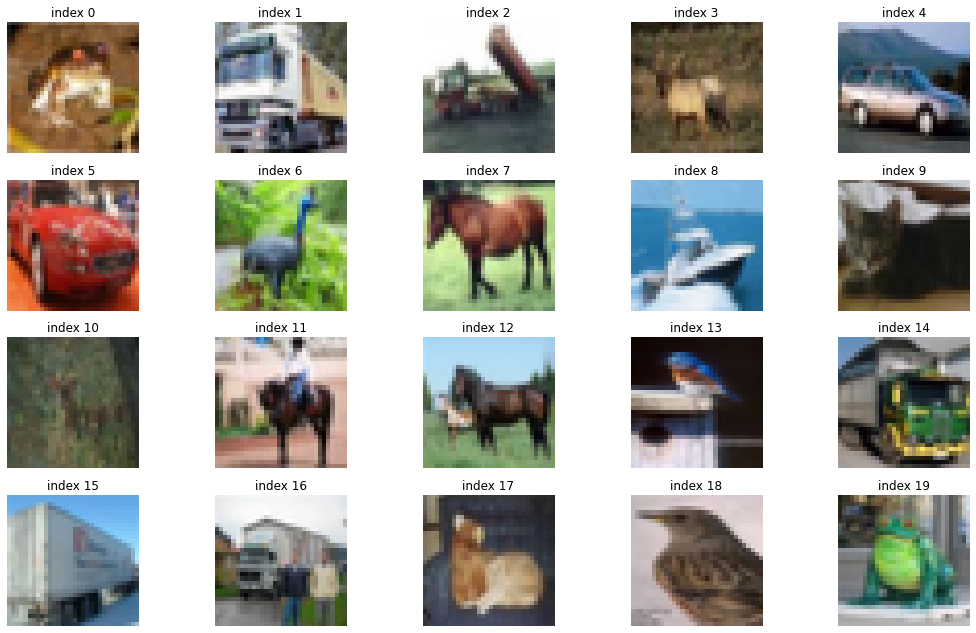

In [8]:
plt.figure(figsize=(18, 14))

for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i, :, :, :])
    plt.axis('off')
    plt.title(f'index {i}')
plt.show()

#### # tf.data.Dataset 화

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

## STEP 3. 생성자 모델 구현하기

- input은 (1, 100) shape를 가진 noise 데이터(어레이)가 될 예정
- output은 (32, 32, 3)을 가진 이미지 형태의 tensor가 되게끔 한다.

> #### note:
> - Conv2DTransopose의 원리, 특히 strides값이 다를 때 어떤 output shape으로 upsampling 되는지 헷갈리니 확인해보자
> - 이를 토대로 (32\*32\*3) shape을 갖도록 설계할 예정이다

In [11]:
test_tensor = tf.zeros((1, 7, 7, 256))
test_tensor.shape

TensorShape([1, 7, 7, 256])

In [12]:
tc_1 = layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False)
out_1 = tc_1(test_tensor)

out_1.shape

TensorShape([1, 7, 7, 128])

In [13]:
tc_2 = layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)
out_2 = tc_2(out_1)

out_2.shape

TensorShape([1, 14, 14, 64])

> #### note:
> - `kernel_size=(5,5)`, `strides=1`, `padding='same'`일 경우 이미지의 가로, 세로 크기가 동일하게 반환되고,
> - `kernel_size=(5,5)`, `strides=2`, `padding='same'`일 경우 이미지의 가로, 세로 크기가 두 배 커진 채로 Conv2DTranspose layer에서는 반환 됨을 확인했다.

#### # generator 모델 설계

- 마지막 층의 activation 함수로 `sigmoid`를 사용했다.
- 이유는 `0 ~ 1`사이의 실수값으로 출력해서 3채널 이미지로서 `plt.imshow()`에서 사용하려 함이다.

In [14]:
# input후 거치는 Dense 레이어에서 8*8 사이즈를 갖도록 하면 끝에 32*32 이미지가 나오는 것 같다.
# 추가로 마지막에 filter 갯수가 3개가 되어야 (32*32*3) 사이즈를 갖게 되는 것 같다.
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='sigmoid'))

    return model

In [15]:
test_model = make_generator_model()
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

## STEP 4. 판별자 모델 구현하기

- 첫번째 레이어의 input_shape에 유념한다.
- generator 후 나온 값을 discriminator 모델로 통과시켜본다.

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [17]:
test_discriminator = make_discriminator_model()
test_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
# generator, discriminator 둘 다 통과시켜보기
test_noise = tf.random.normal((1,100))

generator = make_generator_model()
discriminator = make_discriminator_model()

noise_image = generator(test_noise, training=False) # training=False를 통해 BN이 inference용으로 작동할 수 있게 한다.
noise_output = discriminator(noise_image)

> #### note:
> - 여기서 모르고 습관처럼 `np.random.normal((1,100))`을 했는데, `tf.random.normal((1,100))`과 뱉어내는 shape이 다르다 보니 오류가 났었다.
> - np.random.normal()에서 첫번째 parameter는 shape 관련된 게 아니라 mean 관련된 거여서 위와 같이 코딩할 경우 생성된 어레이의 shape은 (2,)이다.


In [19]:
# tensorflow 자료형의 min, max 구하는 법 확인
print(tf.math.reduce_min(noise_image) == noise_image.numpy().min())
print(tf.math.reduce_max(noise_image) == noise_image.numpy().max())

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)


noise_image.shape : (1, 32, 32, 3)
noise_image.max : 0.514700174331665
noise_image.min : 0.48938652873039246


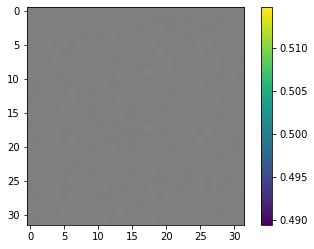

noise_output : [[0.00352442]]
noise_output.shape : (1, 1)


In [20]:
# 시각화 및 아웃풋들 확인
# noise_image 텐서 확인
print(f'noise_image.shape : {noise_image.shape}')
print(f'noise_image.max : {tf.math.reduce_max(noise_image)}')
print(f'noise_image.min : {tf.math.reduce_min(noise_image)}')

plt.imshow(noise_image[0])
plt.colorbar()
plt.show()

print(f'noise_output : {noise_output}')
print(f'noise_output.shape : {noise_output.shape}')

> #### note:
> - noise_image가 `(32, 32, 3)` shape의 어레이로 만들어지는 것을 확인했고, discriminator 통과 후 하나의 확률 값이 반환되는 것을 확인했다.

## STEP 5. 손실함수와 최적화 함수 구현하기

- Loss function 만들기
  - generator의 loss 갯수 = 1개
  - discriminator의 loss 갯수 = 2개
- Optimizer 만들기
  - generator = 1개
  - discriminator = 1개
- Discriminator가 내놓은 판별 값을 갖고 G(), D()각각 `accuracy` 구하는 함수 만들기
  - generator 값 1개
  - discriminator 값 1개


#### # Loss function 만들기

- 궁극적으로 generator, discriminator 둘 다 기준으로 삼는 loss는
- discriminator의 출력값이고, 그것은 입력 이미지의 진/위 여부를 가르는 이진 분류이다.
- 여기서 cross_entropy의 입력값으로 들어오는 discriminator 모델 자체의 출력값은 sigmoid를 거치지 않는 실수여서
- `from_logits` 파라미터를 `True`로 설정해준다.

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
# generator loss
# 입력으로 들어오는 fake_output은 아직 범위가 정해지지 않은 실수값이지만,
# 위 cross_entropy의 from_logits=True 설정을 통해 y_true인 tf.ones_like와
# 확률값으로서 loss 계산이 되게끔 해준다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)    

In [23]:
# discriminator loss
# 여기서는 1 iteration에서 실제 이미지가 들어와서 실제로 맞췄는지에 대한 loss가 계산되게 하고
# 같은 iteration에서 생성 이미지가 들어와서 가짜로 맞췄는지에 대한 loss가 계산되게 한 다음
# 더해준다.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### # Accuracy 계산 function 만들기

In [24]:
# real_output의 판별 후 진짜일 확률이 0.5 이상일 경우 '진짜'로 판별되는 real_output vector 내 요소의 비율과
# fake_output의 판별 후 진짜일 확률이 0.5 미만일 경우 '가짜'로 판별되는 fake_output vector 내 요소의 비율을 계산합니다.
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### # Optimizer 선언

In [25]:
# loss를 계산하는 모델이 두 개이기 때문에 optimizer를 2개 선언
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 6. 훈련과정 상세 기능 구현하기

- input으로 들어가는 고정 noise 벡터 할당
- 중간 시각화 함수 정의
- train 함수 설계

#### # 고정 noise 벡터 만들기

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

> #### note:
> - 위의 seed noise의 경우 샘플이 나오는 분포를 normal distribution으로 하느냐 uniform distribution으로 하느냐에도 차이가 있을 수 있단다.
> - 단순하게 생각하면 이로 인해 모델 파라미터 값이 바뀌게 되고,
> - 최종 output 이미지의 픽셀 값들도 모집단의 분포 형태를 띄고 있지 않을까 추측한다.
> - 그런데 여기서 normal distribution이 좀 더 유리한 이유는 어쩜 실제 세계의 이미지 픽셀 값 분포가 0~255가 골고루 있는 게 아닌가 보다.(그냥 추측해본다.)

#### # 1 iteration train 함수 만들기
> #### including:
> - loss 계산
> - accuracy 계산
> - gradient 계산 및 업데이트
> - 측정 지표 반환

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

> #### note:
> - 위에서 `with tf.GradientTape() as gen_tape....` 구문에서 막상 gen_tape을 사용할 때는 indentation이 없다는 것에 의구심이 들었다.
> - 구글링 결과 이유를 알아냈다.
> - 정리하자면, 저렇게 생성한 gen_tape 객체는 `__enter__()`함수와 `__exit__()` 함수가 내장되어 있는데 그 둘을 통해 `gen_tape`객체가 자원 사용 시작 및 끝을 맺을 수 있게 해주고,
> - indentation 되어 있는 부분은 코드 내에 `gen_tape`객체가 명시적으로 드러나진 않지만, 저런 loss, accuracy 계산 과정을 record하라고 알려주는 것이란다.
> - 그리고 record한다 함은 `tf.GradintTape()`의 역할인 듯하다.

#### # 훈련 중간 generator의 output 이미지 시각화 및 저장 함수

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

#### # 훈련 중간 loss, accuracy 시각화 및 그래프 이미지 저장 함수

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### # checkpoint 선언

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### # 종합 train 함수

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

## STEP 7. 학습 과정 진행하기

In [32]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

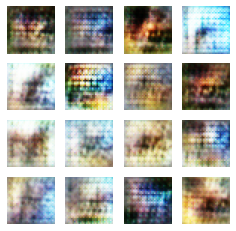

Time for training : 1828 sec


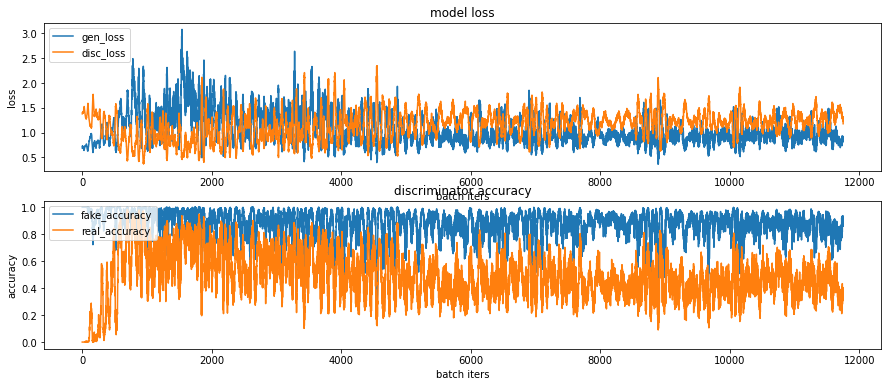

CPU times: user 30min 24s, sys: 34 s, total: 30min 58s
Wall time: 30min 29s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

> #### feedback:
> - discriminator의 accuracy가 중 real accuracy는 `0.4 ~ 0.7` 사이에 분포하고 있다.
> - 반면 fake accuracy는 계속 `0.8 ~ 1.0` 사이에 분포하는데,
> - 결과 이미지를 정성적으로 판별해도 fake임이 눈에 띈다.

#### # 학습과정 시각화하기

In [34]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif

-rw-r--r-- 1 root root 1514878 Feb 12 09:16 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif


## STEP 8. (optional) GAN 훈련 과정 개선하기

- 사실 위의 결과를 봤을 때 1) fake_accuracy가 낮아질 기미가 안 보이는 점과, 2) 현재 epoch 50에서 나온 훈련 결과물의 수준을 보았을 때 해당 모델은 유의미한 GAN으로서 작동하지 않을 것 같다.
- 그래서 다른 GAN을 생성해서 구현해보려 한다.

### 개선 1)
> - 정의하는 문제점 : generator로 생성된 이미지가 아직 수준이 낮다.
> - 솔루션 : generator에 Conv2DTranspose 층을 2개 더 쌓아보자.

#### # generator에 2층 더 넣기

- 추가한 층을 맨 앞과 맨 뒤에 넣을 예정이다.
- 그리고 시작은 (4, 4, 1024)로 시작하고,
- 갈수록 차원 축소 -> 크기 축소를 반복할 예정이다.
- 이를 통해 좀 더 이미지 정보가 풍부해지지 않을까 추측한다.

In [33]:
def make_generator_model_2nd():

    # Start
    model = tf.keras.Sequential()

    # 1) Dense layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2) Reshape layer (4, 4, 1024)로 작지만 depth가 깊게 시작
    model.add(layers.Reshape((4, 4, 1024)))

    # 3) 추가된 층
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4) Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 5) Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 6) 추가된 층
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 7) Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='sigmoid'))

    return model

In [34]:
test_model = make_generator_model_2nd()
test_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 512)        

> #### note:
> - 잘 모르면 파라미터 수로 승부해본다......

#### # 이미지 저장소 따로 만들기

In [37]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples_2nd
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints_2nd
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history_2nd

> #### note:
> - generator는 새로 생성한 모델을 써보고
> - dicsriminator는 아까 생성된 기존의 모델을 계속 사용해서 기존에 학습된 파라미터를 계속해서 써볼 예정이다.
> - 약간은 unfair할 수 있지만, generator의 성능을 개선시키는 게 주 목적이니 좀 더 generator에게 harsh해도 되지 않을까 싶다...


#### # train 관련 함수 업데이트
- 이미지 저장소 root 업데이트
- generator 모델 업데이트

In [35]:
generator_2nd = make_generator_model_2nd()

In [39]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_2nd(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_2nd.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_2nd.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [40]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_2nd/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [41]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_2nd/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [36]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2nd'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_2nd = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator_2nd=generator_2nd,
                                 discriminator=discriminator)

In [43]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_2nd, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_2nd, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [44]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

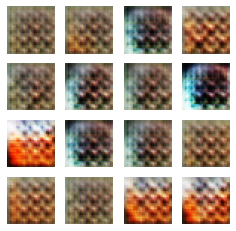

Time for training : 9093 sec


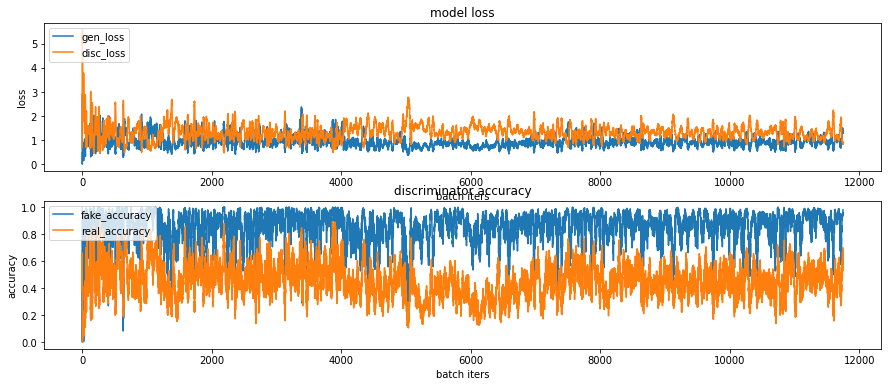

CPU times: user 2h 31min 21s, sys: 34.4 s, total: 2h 31min 55s
Wall time: 2h 31min 34s


In [45]:
%%time
train(train_dataset, EPOCHS, save_every)

> #### feedback:
> `accuracy`
> - 이전보다 fake accuracy가 요동치긴 하지만, 여전히 0.5로 낮아지지 않고 있다.
> - 그러나 정성적인 결과물을 봤을 때는 아직도 육안으로 물체를 구분하기는 어렵다.
> - 그리고 약간의 차이만 있을 뿐 중복 되는 이미지가 많이 보인다.

In [46]:
# GIF로 남기기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_2nd/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif

-rw-r--r-- 1 root root 1508493 Feb 12 11:54 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif


> #### note:
> - 윗 코드의 `frame`관련 수식과 이를 통해 무얼하려는지 궁금하다.

In [47]:
for i in range(len(filenames[:100])):
    print(round(2*(i**0.5)), end=' ')

0 2 3 3 4 4 5 5 6 6 6 7 7 7 7 8 8 8 8 9 9 9 9 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 20 20 20 20 

> #### note:
> - 아마도 많은 이미지 중에 몇몇 이미지를 선별해서 gif로 만드려는 목적인데, 몇몇 이미지 선택하는 간격을 갈수록 넓게 한 듯하다.

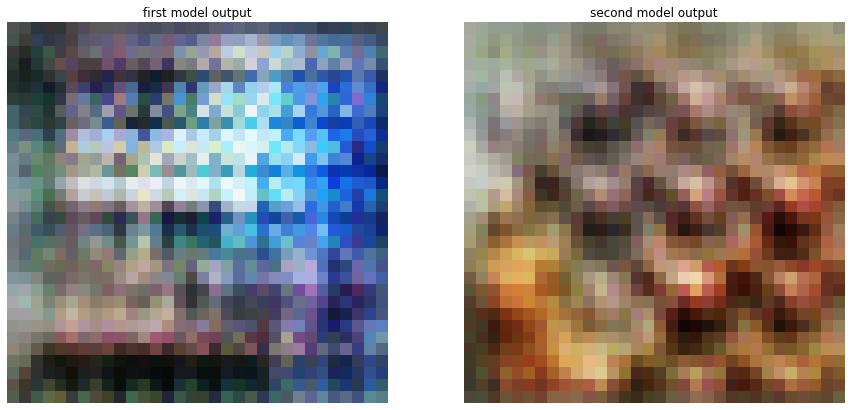

In [50]:
temp_noise = tf.random.normal((1, 100))
output_1 = generator(temp_noise, training=False)
output_2 = generator_2nd(temp_noise, training=False)

plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
plt.imshow(output_1[0])
plt.title('first model output')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_2[0])
plt.title('second model output')
plt.axis('off')

plt.show()

> 그런데 약간 second model output은 좀 더 깊이?가 느껴지지 않나 싶다.

### 개선 2) D()의 loss 변경
> - 어떻게 하면 저기서 더 개선될까?
> - 정의하는 문제점 : 개인적인 짐작으로는 epoch가 낮아서 그런 건지 뭔가 지금의 학습 모델 혹은 학습량이 대체적으로 `실제 이미지` 같이 나올만큼 충분하지 않지 않나 싶다... 즉 더 많은 epoch 같은 게 필요하지 않나 싶다.
> - 솔루션 : 하지만 더 오랜 시간이 걸리는 방법은 비효율적인 것 같다.
>   - 그래서 discriminator의 loss를 변경해볼 예정이다.
>   - loss 계산 시 real 이미지의 라벨을 1로 하지 말고 0.9로 해보자(`one-sided label smoothing` 이란다)

> - 모델을 처음부터 학습시키기에는 시간이 오래 걸려서 사용했던 모델에 추가로 학습시키도록 하겠다.
> - generator는 방금 사용한 2번째 모델,
> - discriminator는 첫번째부터 사용하는 모델

In [68]:
# 이미지 저장소 따로 만들기
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples_3rd
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints_3rd
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history_3rd

In [69]:
# real_loss 부분에 0.9로 곱하는 부분을 추가했다.
def discriminator_loss_smoothe(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [70]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_2nd(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss_smoothe(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_2nd.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_2nd.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [71]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_3rd/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [72]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_3rd/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [46]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_3rd'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_3rd = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator_2nd=generator_2nd,
                                 discriminator=discriminator)

In [74]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_2nd, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_2nd, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

> #### 오랜 학습 시간으로 이번에는 EPOCHS를 줄여볼 예정이다.

In [75]:
save_every = 2
EPOCHS = 20

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

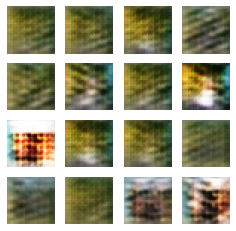

Epoch 16 | iter 151
Time for epoch 16 : 116 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

> #### note:
> - 중간에 학습하다가 끊겼는데 다시 실행하기엔 시간이 오래걸려서 윗 모델들도 노트북을 다시 열고서는 `train`을 실행하지 않았다.

In [48]:
# GIF로 남기기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_3rd/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif

-rw-r--r-- 1 root root 860986 Feb 13 03:19 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif


## 정리
- 중간에 커널 연결이 끊겨서 세 번째 모델의 경우 20 epoch 중 16까지만 진행된 버전으로 정리할 예정이다.

In [43]:
# 고정 노이즈 생성
final_noise = tf.random.normal([1, 100])

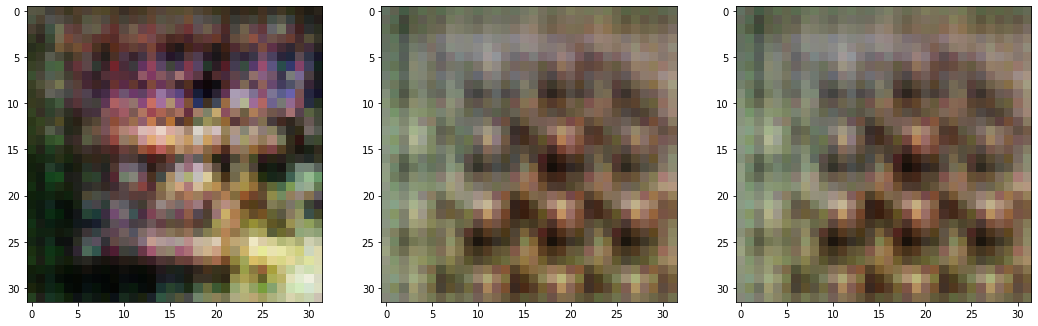

In [47]:

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_dir_2nd = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2nd'
checkpoint_dir_3rd = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_3rd'

latest = tf.train.latest_checkpoint(checkpoint_dir)
latest_2nd = tf.train.latest_checkpoint(checkpoint_dir_2nd)
latest_3rd = tf.train.latest_checkpoint(checkpoint_dir_3rd)

checkpoint.restore(latest)
generator = checkpoint.generator

checkpoint_2nd.restore(latest_2nd)
generator_2nd = checkpoint_2nd.generator_2nd

checkpoint_3rd.restore(latest_3rd)
generator_3rd = checkpoint_3rd.generator_2nd

generated_image = generator(final_noise, training=False)
generated_image_2nd = generator_2nd(final_noise, training=False)
generated_image_3rd = generator_3rd(final_noise, training=False)

np_generated = generated_image.numpy()
np_generated_2nd = generated_image_2nd.numpy()
np_generated_3rd = generated_image_3rd.numpy()

plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.imshow(np_generated[0])
plt.subplot(1,3,2)
plt.imshow(np_generated_2nd[0])
plt.subplot(1,3,3)
plt.imshow(np_generated_3rd[0])

plt.show()



> #### feedback:
> - 모델 3개의 가장 마지막 파라미터로 뽑아낸 이미지이다.
> - 3번째 모델은 2번째 모델에서 약 17에포크나 더 훈련했는데, 해당 파라미터가 저장이 안 된 건지 아님 나의 불러오기 잘못인지 여튼 두 모델의 최종 아웃풋은 비슷해보인다.
> - 아이펠 설명에서는 해당 코드를 사용하면 CIFAR-10 이미지가 보일 것이라 했는데, 아닌 것 같다.
> - #### 결론적으로 CIFAR-10 이미지와 비슷하게 생성해낸 모델을 만들어내진 못했다.

### 학습 내용 정리
- 모델 1, 2, 3 순서로 각각 같은 종류의 이미지를 모아놨다.
- 첫번째 그룹은 seed noise로 생성해본 모델들의 마지막 이미지이고,
- 두번째 그룹은 각각 모델의 학습 그래프이다.
- 세번째 그룹은 seed noise로 생성된 이미지들의 GIF 버전이다.

![](https://images.velog.io/images/moondeokjong/post/935450da-bb81-4621-b5cc-6ae627be1905/model_1_sample_epoch_0050_iter_234.png)

![](https://images.velog.io/images/moondeokjong/post/b09a91bc-ee5e-492a-a7fa-c879d4be85d7/model_2_sample_epoch_0050_iter_234.png)

![](https://images.velog.io/images/moondeokjong/post/0fafb38e-dc17-4c16-a398-26b80e64606a/model_3_sample_epoch_0017_iter_001.png)

![](https://images.velog.io/images/moondeokjong/post/347bf75d-5ac7-4b49-b145-b0eba5ddb5b2/model_1_train_history_0049.png)

![](https://images.velog.io/images/moondeokjong/post/d2dfac24-a29c-49ec-867e-8bb54517b8f1/model_2_train_history_0049.png)

![](https://images.velog.io/images/moondeokjong/post/d3d5a5d5-9dc0-47cc-b2e7-34c1e4641c5b/model_3_train_history_0015.png)

![](https://images.velog.io/images/moondeokjong/post/4e0dbab5-1321-4f2f-8d55-4c7575882fdf/cifar10_dcgan_1.gif)

![](https://images.velog.io/images/moondeokjong/post/8e41713c-a583-48a2-b945-63a31547713a/cifar10_dcgan_2.gif)

![](https://images.velog.io/images/moondeokjong/post/a1f0f645-6fb5-4848-87d1-d4c0083ade38/cifar10_dcgan_3.gif)

#### 학습 중간 checkpoint 로드가 필요할 경우
```python

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

```

## 회고
#### Point 1) Conv2D, Conv2DTranspose 레이어는 왜 kernel_size를 `(5,5)`로 사용했을까...?
- 결론적으로는 아직 정확히 이해되지는 않는다.(이해를 위해서는 Conv2DTraspose의 계산 방법을 이해해야 할 것 같다.)
- kernel_size가 커지면 output activation map의 사이즈도 커진다고 하는데,
- 하지만 이는 strides, padding과 연계되어 output 사이즈를 만들어내는 것이어서 단순히 kernel_size만으로 정의하긴 힘들 것 같다. 

#### Point 2) discriminator는 왜 loss값을 2개 구해서 더할까?
- 생각해보니 기존 모델은 라벨 1, 라벨 0이 동시에 하나의 배치 안에서 들어온다. 그렇기에 하나의 loss값 계산으로 두 라벨에 대한 로스가 구해지고 합쳐질 수 있는데,
- 여기서는 라벨 1과 라벨 0이 각각 다른 배치로서 들어간다.
- 이 경우 라벨 1만 들어간 배치에서는 수식적으로 라벨 0에 대한 loss가 구해질 수 없기에 각각 배치에 대한 로스를 구한 후 더해줘야 라벨 1, 라벨 0에 대한 판별 loss 개선이 가능한 것으로 판단했다.

#### Point 3) Accuracy 계산 함수
- 사실 위의 Accuracy 계산 함수가 수학적으로 맞는지 헷갈린다.(아래의 코드를 보자)
```python
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy
```

- 의미상 `real_output`과 `fake_output`이 `0 ~ 1`사이의 값으로서 `0.5`이상이면 real로 판단하는 것이고, 미만이면 fake로 판단하자는 것 같은데,
- 사실 여기서 `real_output`과 `fake_output`은 엄밀히 말하자면 `sigmoid`를 거치지 않은 모든 실수값을 나타내고 있지 않나 싶다.(discriminator 마지막 레이어에는 활성화 함수가 없다.)
- 그래서 generator -> discriminator의 모델 구조를 보면 음수도 나올 수 있을 것 같고(활성화 함수도 Leaky ReLU니까),
- 이에 따라 상대적으로 음수가 많을 수 있으니 당연히 0.5보다 작은 비율을 세는 fake_accuracy가 더 높게 나오지 않나 싶다.(역으로 real_input이 뚜렷하게 실제 이미지 같음에도 real_accuracy가 낮은 이유가 이것이 아닌가 싶다.)
- 즉, 내가 해석한 윗 코드의 의미가 맞다면, `real_output`, `fake_output`은 먼저 `sigmoid`를 거쳐야 하지 않나 싶다.(사실 큰 확신 없는 개인적인 추측이어서 코드를 변경해서 실행하지 않아봤다.)

#### Point 4) GAN의 training
- 눈에 띌 만한 결과가 나오려면 시간이 많이 걸리는 것 같다...
- 그래서 빠른 학습 수렴이 핵심인 것 같은데,
- 그래서 vanishing gradient 문제나 normalization이 중요한 것 같고,
- 그렇다 보니 모델 중간 중간의 활성화 함수도 많이 신경 쓰는 것 같다.(GAN Training 관련 블로그 참조 시)